In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

Using TensorFlow backend.


In [2]:
#Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp '/content/drive/My Drive/Colab Notebooks/9. Data Augmentation/cifar-10-python.tar.gz' '/content/cifar-10-batches-py.tar.gz'

In [4]:
!mkdir ~/.keras/datasets

mkdir: cannot create directory ‘/root/.keras/datasets’: File exists


In [0]:
!cp '/content/cifar-10-batches-py.tar.gz' ~/.keras/datasets/

In [6]:
ls ~/.keras/datasets

cifar-10-batches-py/  cifar-10-batches-py.tar.gz


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [8]:
from skimage import io
from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/9. Data Augmentation/model_accuracy.best.hdf5')
img = test_features[0]
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0702 16:00:17.913381 139915123423104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 16:00:17.932562 139915123423104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 16:00:17.961782 139915123423104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 16:00:17.962745 139915123423104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0702 16:00:17.964769 139915123

In [9]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_11")

1


In [10]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(10): #changed from 512 to 10 as we have 10 channel
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 1, 1, 10)
(10,)


In [11]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(1, 1, 10)
(1, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


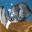

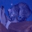

In [18]:
heatmap = cv2.resize(heatmap, (32, 32))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2_imshow(superimposed_img)